# GraphSAGE on the reddit dataset ingested from Neo4j

This notebook provides an example of running the the GraphSAGE algorithm with data loaded from Neo4J. The dataset used is `reddit`. 

Key summary:
- End-to-end ingestion: The reddit dataset is entirely loaded in Neo4j, including node features, node class labels (from 0 - 40), information about which nodes are used for training/validation/testing. This eliminates the need for loading any other auxiliary data during the process.

- Graph structure is then stored in a networkX object, while all node features are preserved within pandas dataframe. 

In [1]:
import json
import numpy as np
import networkx as nx
import pandas as pd
import os
import time
import py2neo

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

cal = False

## Load reddit dataset from Neo4J

The reddit dataset can be downloaded from <a href="http://snap.stanford.edu/graphsage/">here</a>.

<blockquote>Reddit is a large online discussion forum where users post and comment on content in different topical communities. We constructed a graph dataset from Reddit posts made in the month of September, 2014. The node label in this case is the community, or “subreddit”, that a post belongs to. We sampled 50 large communities and built a post-to-post graph, connecting posts if the same user comments on both source and destination node.</blockquote>

In [2]:
def get_edges_from_neo4j(scheme, host, username, password):
    
    neo4j_graphdb = py2neo.Graph(scheme=scheme, host=host, auth=(username, password))
    
    fetch_rel_query = "MATCH (source)-[relationship]->(target) RETURN id(source) as source, id(target) as target;"
    
    rel_records = neo4j_graphdb.run(fetch_rel_query)    
    
    return pd.DataFrame(rel_records).rename(columns={0:'source', 1:'target'})

start = time.time()
edge_df = get_edges_from_neo4j(scheme="bolt", host="localhost", username="neo4j", password="reddit")
edge_df['label'] = 'same_user'
end = time.time()

print(f"{end - start} s: Loading all edges from neo4j database to memory.")


#import the edge dataframe into NetworkX graph object
#nx_graph = nx.from_pandas_edgelist(edge_df, 'SOURCE', 'TARGET', create_using=nx.MultiGraph())

117.29327344894409 s: Loading all edges from neo4j database to memory.


In [3]:
def get_nodes_from_neo4j(scheme, host, username, password):
    
    neo4j_graphdb = py2neo.Graph(scheme=scheme, host=host, auth=(username, password))
    
    fetch_node_query = "MATCH (node) RETURN id(node), properties(node)"

    #run the node-fetching query
    node_records = neo4j_graphdb.run(fetch_node_query)

    #convert the node records into pandas dataframe
    return pd.DataFrame(node_records).rename(columns = {0:'id', 1:'attr'})

start = time.time()
node_df = get_nodes_from_neo4j(scheme="bolt", host="localhost", username="neo4j", password="reddit")
end = time.time()

print(f"{end - start} s: Loading all vertices from neo4j database to memory")
node_df.head(5)

151.06284642219543 s: Loading all vertices from neo4j database to memory


,id,attr
0,0,"{'val': False, 'features': [254.0, 3093.0, 0.0..."
1,1,"{'val': False, 'features': [5.0, 1.0, 0.024994..."
2,2,"{'val': False, 'features': [6.0, 3.0, 0.021834..."
3,3,"{'val': False, 'features': [5.0, 1.0, 0.026114..."
4,4,"{'val': False, 'features': [2.0, 73.0, 0.00260..."


### Data preprocessing
Flatten the attribute dictionary and concatenate with the Neo4J node id.

In [4]:
attr_df = node_df['attr'].apply(pd.Series).drop(labels = ['postID'], axis = 1)

node_df = pd.concat([node_df['id'], attr_df], axis = 1) #.sort_values(by='id', ascending = True)

#set index to id column so that nodes on NetworkX object will be matched correctly with its features
node_df = node_df.set_index('id')
node_df

,val,features,test,post_name,class
id,,,,,
0,False,"[254.0, 3093.0, 0.0038812849670648575, 0.01511...",True,2hgylt,30
1,False,"[5.0, 1.0, 0.02499435469508171, -0.00836942344...",False,2g1zkx,17
2,False,"[6.0, 3.0, 0.02183488756418228, 0.003199644386...",True,2hgyls,18
3,False,"[5.0, 1.0, 0.026114029809832573, 0.00734782963...",False,2f6ifj,23
4,False,"[2.0, 73.0, 0.0026064557023346424, 0.024893743...",False,2g3fjh,22
5,True,"[7.0, 0.0, 0.04457723721861839, 0.003822805127...",False,2h74lt,15
6,False,"[12.0, 4.0, 0.004076262470334768, -0.006458249...",False,2g9w2s,33
7,True,"[5.0, 0.0, -0.018937064334750175, -0.000587218...",False,2h5erw,14
8,False,"[2.0, 2.0, 0.1045636236667633, 0.0002368068089...",False,2fj5f2,38


In [5]:
feats_df = pd.DataFrame(node_df['features'].values.tolist(), index=node_df.index)

In [6]:
if not cal:
    feats_df[0] = np.log(feats_df[0] + 1.0)
    feats_df[1] = np.log(feats_df[1] - min(np.min(feats_df[1]), -1))
    cal = True

In [7]:
labels = np.array(node_df['class'])

target_encoding = preprocessing.OneHotEncoder(sparse=False, categories='auto')
targets = target_encoding.fit_transform(labels.reshape(-1, 1))
targets = pd.DataFrame(targets, index=node_df.index)

### Split the data
Split the dataset based on the provided attributes __test__ and __val__

In [8]:
train_mask = (node_df['test'] == False) & (node_df['val'] == False)
val_mask = (node_df['val'] == True)
test_mask = (node_df['test'] == True)

scaler = preprocessing.StandardScaler()
scaler.fit(feats_df[train_mask].values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [9]:
train_data, train_targets = feats_df[train_mask], targets[train_mask]
val_data, val_targets = feats_df[val_mask], targets[val_mask]
test_data, test_targets = feats_df[test_mask], targets[test_mask]

print(f"{len(train_data)} training nodes")
print(f"{len(val_data)} validation nodes")
print(f"{len(test_data)} testing nodes")

153932 training nodes
23699 validation nodes
55334 testing nodes


Create the networkx object to store the graph structure

In [10]:
Gnx = nx.from_pandas_edgelist(edge_df, edge_attr='label')
Gnx.add_nodes_from(list(node_df.index))
nx.set_node_attributes(Gnx, 'post', 'label')
nx.info(Gnx)

'Name: \nType: Graph\nNumber of nodes: 232965\nNumber of edges: 11606919\nAverage degree:  99.6452'

## Creating GraphSAGE model in Keras

Create the StellarGraph object from the graph structure stored in NetworkX. GraphSAGE algorithm will be performed in this object.

In [11]:
sgG = sg.StellarGraph(Gnx, node_features = feats_df)
print(sgG.info())

NetworkXStellarGraph: Undirected multigraph
 Nodes: 232965, Edges: 11606919

 Node types:
  post: [232965]
    Edge types: post-same_user->post

 Edge types:
    post-same_user->post: [11606919]



We need a data generator that feeds data from the graph to the model. The generators are specific to the model and the learning task so we choose the `GraphSAGENodeGenerator` as we are predicting node attributes with a GraphSAGE model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer, and 5 in the second layer.

In [12]:
batch_size = 300
num_samples = [10, 5]
generator = GraphSAGENodeGenerator(sgG, batch_size, num_samples)

train_gen = generator.flow(train_data.index, train_targets, shuffle = True)
test_gen  = generator.flow(test_data.index, test_targets)
val_gen   = generator.flow(val_data.index, val_targets)

In [13]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32],
    generator=generator,
    bias=True,
    dropout=0.5,
)

In [14]:
#create a model to predict 41 subreddit communities using Keras softmax layers.
x_inp, x_out = graphsage_model.build()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Training the model

In [15]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer = optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"]
)

In [16]:
history = model.fit_generator(
    train_gen,
    epochs=20,
    validation_data =val_gen,
    verbose = 2,
    shuffle=False
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 514 steps, validate for 79 steps
Epoch 1/20
514/514 - 359s - loss: 1.9488 - acc: 0.5100 - val_loss: 0.9342 - val_acc: 0.7876
Epoch 2/20
514/514 - 360s - loss: 1.0627 - acc: 0.7236 - val_loss: 0.6460 - val_acc: 0.8426
Epoch 3/20
514/514 - 361s - loss: 0.8863 - acc: 0.7661 - val_loss: 0.5041 - val_acc: 0.8849
Epoch 4/20
514/514 - 362s - loss: 0.8084 - acc: 0.7856 - val_loss: 0.4659 - val_acc: 0.8836
Epoch 5/20
514/514 - 362s - loss: 0.7714 - acc: 0.7946 - val_loss: 0.4271 - val_acc: 0.8960
Epoch 6/20
514/514 - 362s - loss: 0.7422 - acc: 0.8022 - val_loss: 0.4069 - val_acc: 0.9031
Epoch 7/20
514/514 - 372s - loss: 0.7255 - acc: 0.8066 - val_loss: 0.4032 - val_acc: 0.9009
Epoch 8/20
514/514 - 361s - loss: 0.7057 - acc: 0.8113 - val_loss: 0.3912 - val_acc: 0.9021
Epoch 9/20
514/514 - 361s - loss: 0.6978 - acc: 0.8139 - val_loss: 0.4057 - val_acc: 0.8967
Epo

In [17]:
def plot_history(history):
    
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    
    for m in metrics:
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='best')
        plt.show()

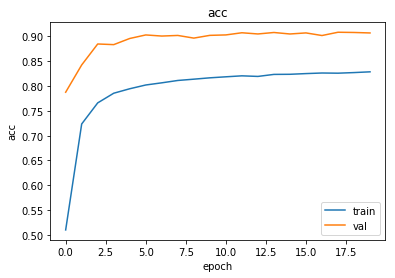

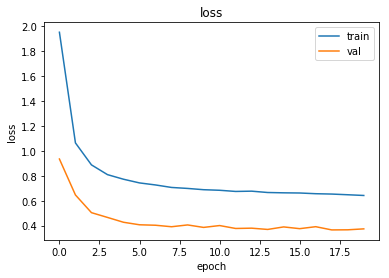

In [18]:
plot_history(history)

Evaluate the model on the test set

In [19]:
test_metrics = model.evaluate_generator(test_gen)

print("\nTest Set Metrics:")

for name, val in zip(model.metrics_names, test_metrics):
    print(f"\t{name}: {val:0.4f}")

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']

Test Set Metrics:
	loss: 0.3878
	acc: 0.9053


### Making predictions with the model
Present the prediction on the test set

In [20]:
#truth value of the test set
test_labels = labels[test_mask]

In [21]:
test_nodes = test_data.index
test_mapper = generator.flow(test_nodes)
test_predictions = model.predict_generator(test_mapper)

Instructions for updating:
Please use Model.predict, which supports generators.


Use `inverse_transform` to turn the values back to the categories

In [22]:
#prediction value
node_predictions = target_encoding.inverse_transform(test_predictions)

In [23]:
eval_df = pd.DataFrame({"Prediction": np.amax(node_predictions, axis=1), "Truth": test_labels})
eval_df.head(10)

,Prediction,Truth
0,30,30
1,18,18
2,18,18
3,0,0
4,3,28
5,18,18
6,9,9
7,15,15
8,19,19
9,31,31


Save the whole graph in the form of `graphml`, for further visualisation in [Gephi](https://gephi.org)

In [24]:
all_nodes = node_df.index
all_mapper = generator.flow(all_nodes)
all_predictions = np.argmax(model.predict_generator(all_mapper), axis=1)
all_df = pd.DataFrame({"Prediction" : all_predictions, "Truth": labels}, index=node_df.index)

In [25]:
for node_id, pred, truth in zip(all_df.index, all_df["Prediction"], all_df["Truth"]):
    Gnx.nodes[node_id]["class"] = truth
    Gnx.nodes[node_id]["PREDICTED_class"] = pred

In [26]:
for node_id in train_data.index:
    Gnx.nodes[node_id]["isTrain"] = True

for node_id in test_data.index:
    Gnx.nodes[node_id]["isTrain"] = False
    
for node_id in val_data.index:
    Gnx.nodes[node_id]["isTrain"] = False

for node_id in Gnx.nodes():
    Gnx.nodes[node_id]["isCorrect"] = Gnx.nodes[node_id]["class"] == Gnx.nodes[node_id]["PREDICTED_class"]

Save in GraphML format

In [27]:
output_dir = os.path.expanduser('~/data/reddit/result')

In [28]:
pred_fname = f"pred_n={num_samples}.graphml"
nx.write_graphml(Gnx, os.path.join(output_dir, pred_fname))

## Node embeddings

Evaluate node embeddings as activations of the output of graphsage layer stack, and visualise them, coloring nodes by their class label.

The GraphSAGE embeddings are the output of the GraphSAGE layers, namely the `x_out` variable. Let's create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [29]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [30]:
emb = embedding_model.predict_generator(test_mapper)
print(emb.shape)

(55334, 32)


In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [34]:
X = emb
Y = np.argmax(target_encoding.transform(eval_df[["Truth"]]), axis=1)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their class label.

In [35]:
if X.shape[1] > 2:
    transform = TSNE
    
    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=test_data.index)
    emb_transformed['label'] = Y

else:
    emb_transformed = pd.DataFrame(X, index=node_df.index)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = Y
    

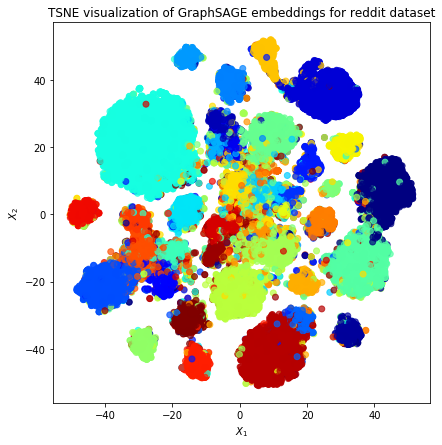

In [36]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(emb_transformed[0], emb_transformed[1], c = emb_transformed['label'].astype("category"), 
          cmap = "jet", alpha=alpha)

ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")

plt.title(f"{transform.__name__} visualization of GraphSAGE embeddings for reddit dataset")
plt.show()

## Export result into csv for visualization in NeoStack

Create dataframe for exporting, especially for node list.

In [38]:
node_df['predicted'] = all_predictions
node_df['usage'] = None

node_df['usage'][train_mask] = 'train'
node_df['usage'][val_mask] = 'val'
node_df['usage'][test_mask] = 'test'

result = node_df.drop(labels = ['test','val','features'], axis = 1)


/home/ho049/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ho049/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ho049/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
result.to_csv(os.path.join(output_dir, 'nodelist.csv'), header = True, index = True)
edge_df.to_csv(os.path.join(output_dir, 'edgelist.csv'), header = True, index = True)